### **本节介绍快速导数计算——误差反向传播法**

**理解**：基于**计算图**

**基本原理**：多元导数的**链式法则**（微积分里有学，不过多赘述）

**主要两个层**：  
（1）加法层：保留上游传下的导数继续往前传  
（2）乘法层：乘法的反向传播会将上游的值乘以**正向传播时的输入信号**的**翻转值**后传递给下游

**加法图**：

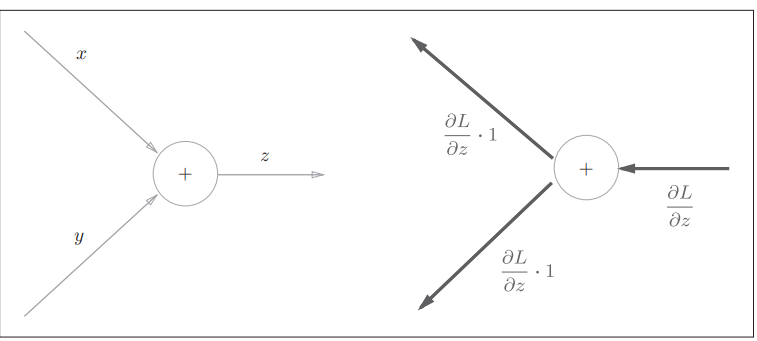

**乘法图**：

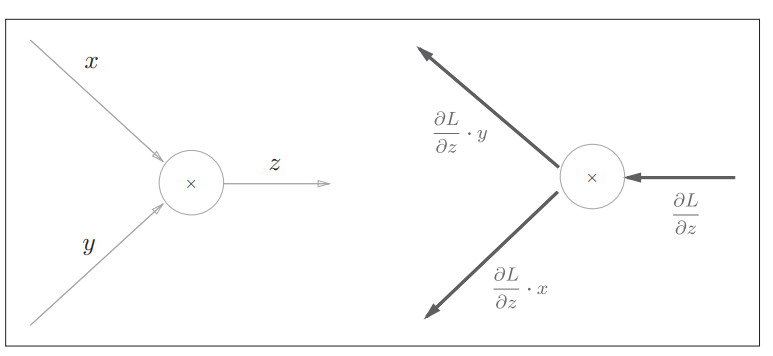

***

In [1]:
# 导入包
import numpy as np

**下面是简单乘法层的类实现**

In [2]:
class MulLayer:
    """简单乘法层"""
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self,x,y):
        self.x = x
        self.y = y
        out = x*y

        return out

    def backward(self,dout):
        dx = self.y*dout # 翻转信号
        dy = self.x*dout

        return dx,dy

***
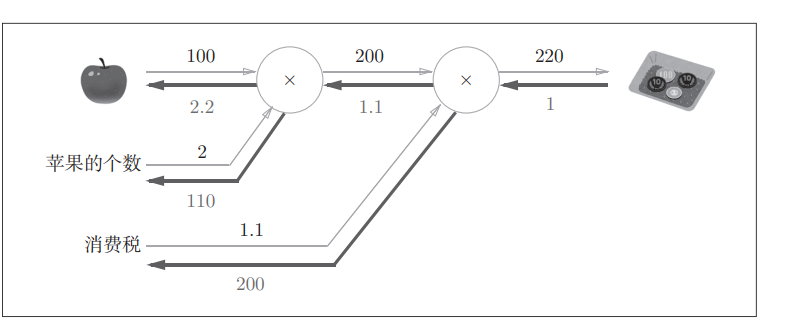

下面应用乘法层模拟上面的过程

In [3]:
apple = 100
apple_num = 2
tax = 1.1

# 定义layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward处理
apple_price = mul_apple_layer.forward(apple,apple_num)
price = mul_tax_layer.forward(apple_price,tax)

print(price) # 220

# backward处理
dprice = 1
dapple_price,dtax = mul_tax_layer.backward(dprice) # 要与输入的时候一一对应
dapple,dapple_num = mul_apple_layer.backward(dapple_price) # 注意返回顺序要与输入一一对应

print(dapple,dapple_num,dtax) # 2.2   110   200 结果正确

220.00000000000003
2.2 110.00000000000001 200


调用backward()的顺序与调用forward()的**顺序相反**。  
此外，要注意backward()的参数中需要输入**关于正向传播时的输出变量的导数**。  
比如，mul_apple_layer乘法层在正向传播时会输出apple_price，在反向传播时，则会将apple_price的导数dapple_price设为参数。

***

**下面是加法层的实现**

In [4]:
class AddLayer:
    """加法层的实现"""
    def __init__(self):
        pass

    def forward(self,x,y):
        out = x + y
        return out
    
    def backward(self,dout):
        dx = dout*1
        dy = dout*1

        return dx,dy

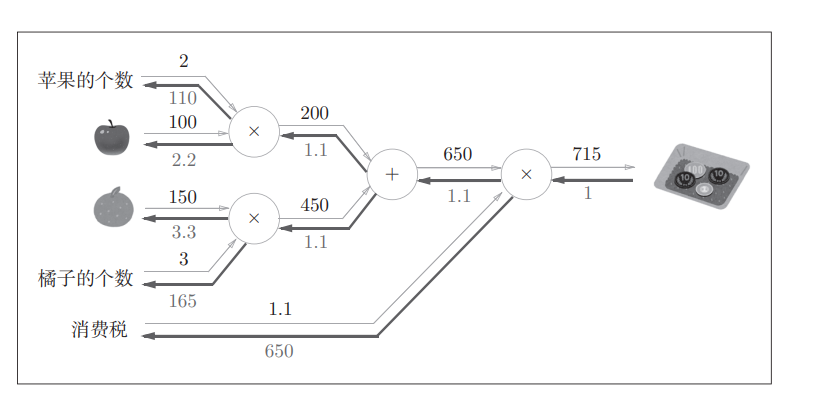

下面利用加法与乘法层实现上面的**计算图**

In [5]:
# 定义初始输入变量
apple_single_price = 100
apple_num = 2
orange_single_price = 150
orange_num = 3
tax = 1.1

# 定义节点，即层
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange = AddLayer()
mul_tax_layer = MulLayer()

# 进行forward处理
apple_price = mul_apple_layer.forward(apple_single_price,apple_num) # 苹果单价x数量 (1)
orange_price = mul_orange_layer.forward(orange_single_price,orange_num) # 橘子单价x数量 (2)
add_price = add_apple_orange.forward(apple_price,orange_price) # 苹果总价+橘子总价 (3)
price = mul_tax_layer.forward(add_price,tax) # 税后总价 (4)

# 进行backward处理
dprice = 1
dadd_price,dtax = mul_tax_layer.backward(dprice) # (4)
dapple_price,dorange_price = add_apple_orange.backward(dapple_price) # (3)
dorange_single_price,dorange_num = mul_orange_layer.backward(dorange_price) # (2)
dapple_single_price,dapple_num = mul_apple_layer.backward(dapple_price) # (1)

print(price)
print(dapple_single_price,dapple_num,dorange_single_price,dorange_num,dtax) # 2.2  110  3.3  165  650

# 与图片中的结果一致

715.0000000000001
2.2 110.00000000000001 3.3000000000000003 165.0 650


***
**下面是激活函数的反向传播方法**

**一，relu函数的反向传播**

relu函数：
$ \large y = \begin{cases}
x \quad (x > 0)\\
0 \quad (x \leq 0)\\
\end{cases} $

求导后:
$ \dfrac{\partial y}{\partial x} = \large \begin{cases}
1 \quad (x > 0)\\
0 \quad (x \leq 0)\\
\end{cases} $

计算图如下：

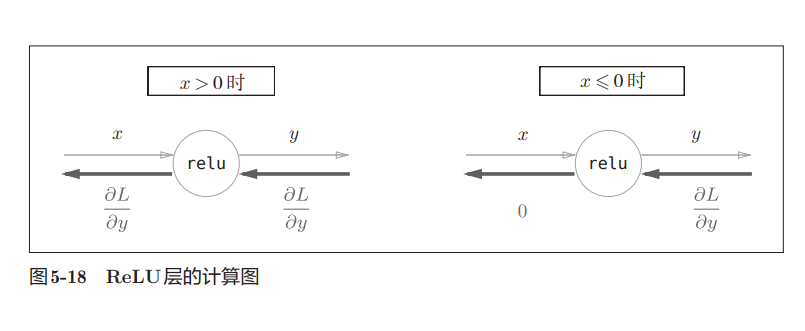

**下面代码实现这个节点的类**

In [1]:
# relu计算节点
class Relu:
    """Relu函数的计算层"""

    def __init__(self):
        self.mask = None

    def forward(self,x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0 # 这个用法要学会；将True位置数置零

        return out
    
    def backward(self,dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

***
**二，sigmoid函数的反向传播**

sigmoid函数：
$ y = \Large \frac {1}{1 + e^{-x}} $

**用计算图表示**：

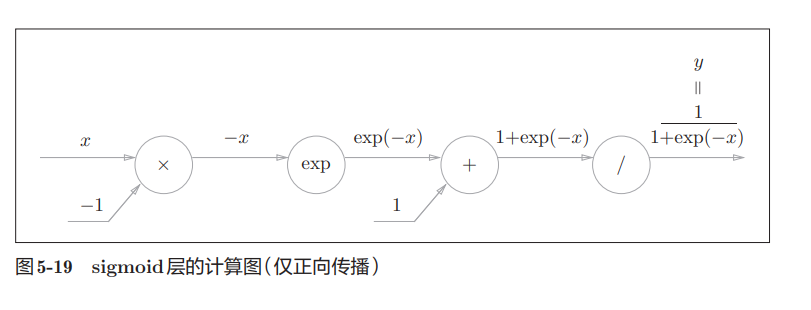

**反向求导过程**：

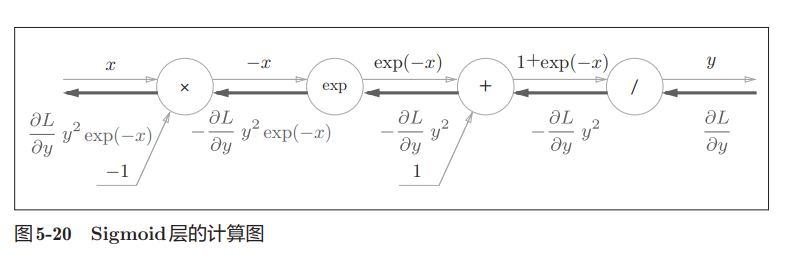

**简化后的sigmoid节点**：

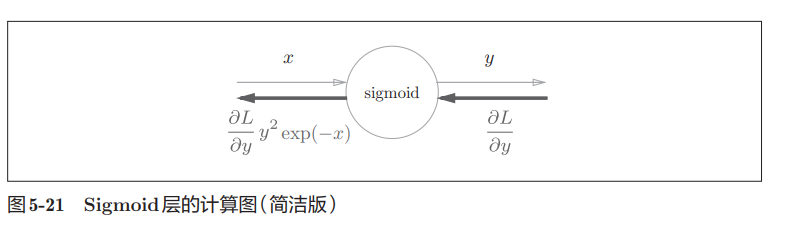

注意到式子还可以进一步化简:

$ y = {\Large \frac {1}{1 + e^{-x}}} $

$\dfrac{\partial L}{\partial y} y^2\;exp(-x) = \dfrac{\partial L}{\partial y}y(1-y)$

**故有最简sigmoid节点**：

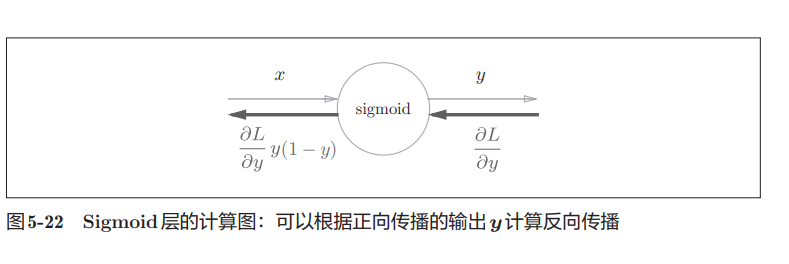
***
**下面是代码实现sigmoid计算层**

In [7]:
# sigmoid计算节点
class Sigmoid:
    """sigmoid计算节点"""
    def __init__(self):
        self.out = None
    
    def forward(self,x):
        out = 1/(1 + np.exp(-x))
        self.out = out

        return out
    
    def backward(self,dout):
        dx = dout*self.out*(1.0 - self.out)

        return dx